In [1]:
using DataFrames, CSV
using Statistics, NaNMath
using Plots, StatsPlots, ColorSchemes, Plots.Measures
using SpecialFunctions
using DifferentialEquations, DiffEqFlux

function c(x, t)
    L = sqrt(D*t)
    return erfc.(x / L)
end

function int_c(h)
    L = sqrt(D*dt)
    t1 = L*(-exp.(-h^2 / (L^2)))
    t2 = sqrt(π) * h * erfc(h/L)
    return (t1 + t2 + L)
end


G(z, zstar) = z < zstar ? z : zstar 

function diff_nutrient(h, L)
    t1 = L*(-exp.(-h^2 / (L^2)))
    t2 = sqrt(π) * h * erfc(h/L)
    return (t1 + t2 + L)
end

function interface_limited(du, u, p, t)
    h = u[1] 
    α, β, hstar = p
    du[1] = α*G.(h, hstar) - β*h 
    return du
end

function diffusion_limited(du, u , p, t)
    h = u[1]
    α, β, L = p 
    du[1] = α*diff_nutrient(h, L) - β*h 
    return du
end

function if_fit(time_data, x_data, p)
    u0 = x_data[1]  
    prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
    function loss(p)
        sol = solve(prob, Tsit5(), p=p, saveat=time_data) # Force time savings to match data
        sol_array = reduce(vcat, sol.u)
        loss = sum(abs2, sol_array .- x_data)
        return loss, sol
    end
    result_ode = DiffEqFlux.sciml_train(loss, p,
                                        maxiters=100)
    return result_ode.u
end

function di_fit(time_data, x_data, p)
    u0 = x_data[1]  
    prob = ODEProblem(diffusion_limited, [u0], (0.0, 50.0), p) # Set the problem
    function loss(p)
        sol = solve(prob, Tsit5(), p=p, saveat=time_data) # Force time savings to match data
        sol_array = reduce(vcat, sol.u)
        loss = sum(abs2, sol_array .- x_data)
        return loss, sol
    end
    result_ode = DiffEqFlux.sciml_train(loss, p,
                                        maxiters=100)
    return result_ode.u
end

di_fit (generic function with 1 method)

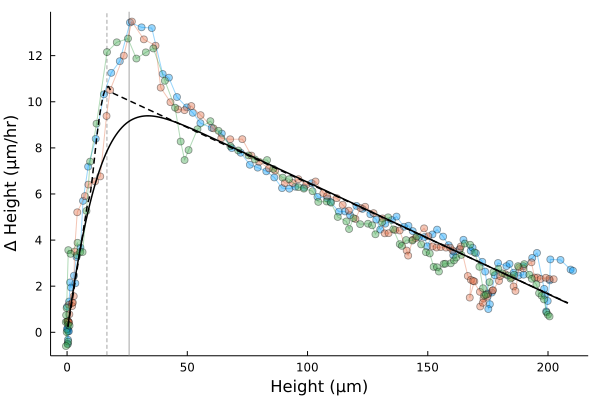

In [8]:
df = DataFrame(CSV.File("/home/pablo/Documents/Yggdrasil/Files/biofilm_surface_growth/data/timelapses/database.csv"))
aero = filter(row->row.Strain.=="BGT127"&&row.Time.<=48, df);
my_strain, my_replicate = "BGT127", "A"
tf =  filter(row -> row.Replicate .== my_replicate && 
             row.Strain .== my_strain, df);
p = [1.0, 0.05, 15.0]

##
prob = ODEProblem(diffusion_limited, [tf.loess_height[1]], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=tf.Time)

##
iffit = if_fit(tf.Time, tf.loess_height, p)
difit = di_fit(tf.Time, tf.loess_height, p)

##
probdi = ODEProblem(diffusion_limited, [tf.loess_height[1]], (0.0, 50.0), difit) # Set the problem
soldi = solve(probdi, saveat=tf.Time)
probif = ODEProblem(interface_limited, [tf.loess_height[1]], (0.0, 50.0), iffit) # Set the problem
solif = solve(probif, saveat=tf.Time)
err_di = sqrt(mean(abs2, reduce(vcat, soldi.u) .- tf.avg_height))
err_if = sqrt(mean(abs2, reduce(vcat, solif.u) .- tf.avg_height))

##
soldi = solve(probdi, saveat=0.1)
hdi = reduce(vcat, soldi.u)
dh_di = (hdi[2:end]-hdi[1:end-1])/0.1
solif = solve(probif, saveat=0.1)
hif = reduce(vcat, solif.u)
dh_if = (hif[2:end]-hif[1:end-1])/0.1

plot()
vline!([difit[3]], color=:gray, alpha = 0.7, legend=:right, label=false)
vline!([iffit[3]], color=:gray, alpha = 0.7, linestyle=:dash, legend=:right, label=false)
@df aero plot!(:avg_height, :local_slope, group=(:Replicate), marker=:circle, alpha=0.4, grid=false,
            xlabel="Height (μm)", ylabel="Δ Height (μm/hr)",legend=false, color=[1,2,3]')
plot!(hdi[1:end-1], dh_di, color=:black, linewidth=1.5)
plot!(hif[1:end-1], dh_if, color=:black, linestyle=:dash, linewidth=1.5)

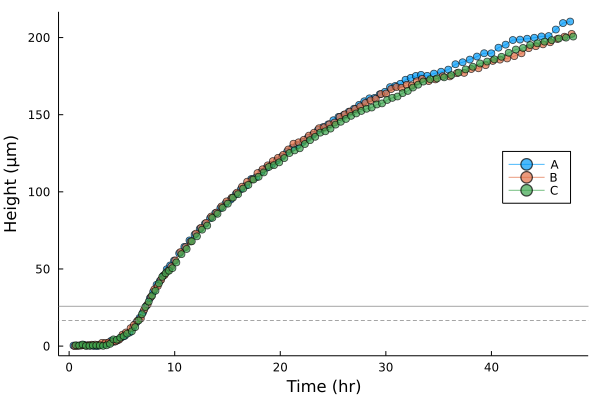

In [4]:
@df aero plot(:Time, abs.(:avg_height), group=(:Replicate), alpha=0.7, grid=false,
            xlabel="Time (hr)", ylabel="Height (μm)",legend=false, marker=:circle,
            )
hline!([difit[3]], color=:gray, alpha = 0.7, legend=:right, label=false)
hline!([iffit[3]], color=:gray, alpha = 0.7, linestyle=:dash, legend=:right, label=false)

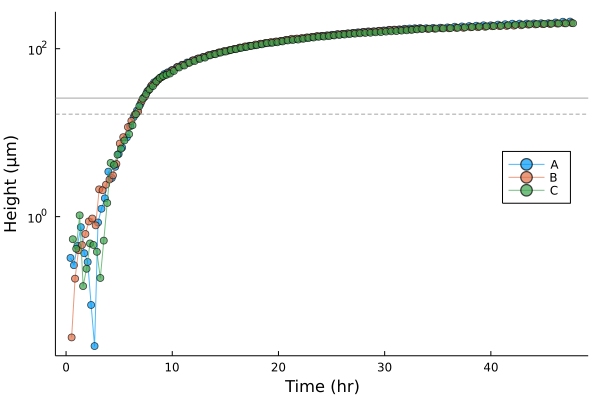

In [6]:
@df aero plot(:Time, abs.(:avg_height), group=(:Replicate), marker=:circle, alpha=0.7, grid=false,
            xlabel="Time (hr)", ylabel="Height (μm)", yscale=:log10, legend=false)
hline!([difit[3]], color=:gray, alpha = 0.7, legend=:right, label=false)
hline!([iffit[3]], color=:gray, alpha = 0.7, linestyle=:dash, legend=:right, label=false)

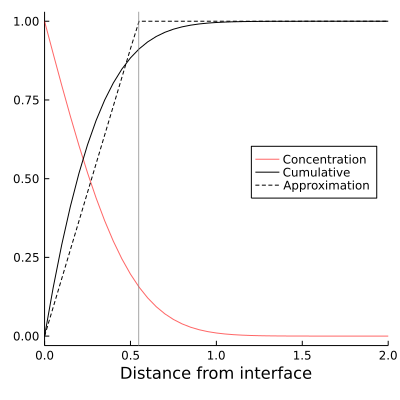

In [7]:
x = Array(0.0:0.05:3.0)
D = 0.3
dt = 1.0
y = exp.(-D*x)
myc = c(x, dt)
a = int_c(0.1)
sol_dis = cumsum(c(x, dt)) .- 1
sol_ana = int_c.(x)
sol_dis = G.(x, sqrt(D*dt))
plot(x, myc, xlabel="Distance from interface", grid=false, alpha=0.6, color=:red, label="Concentration", size=(400, 400), xlim=(0,2))
plot!(x, sol_ana ./ maximum(sol_ana), color=:black, label="Cumulative", xlim=(0,2))
plot!(x, sol_dis ./ maximum(sol_dis), color=:black, linestyle=:dash,label="Approximation")
vline!([sqrt(D*dt)], color=:gray, alpha = 0.7, legend=:right, label=false)
#savefig("figs/figs_temp/infinitesource0.svg")

LoadError: UndefVarError: plt not defined